<a href="https://colab.research.google.com/github/AnaKarenDRIV/FinanzasUniversitarias/blob/main/simulacion%201/simulacion_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:

# CELDA 1: Instalación
!pip install sentence-transformers fuzzywuzzy python-levenshtein torch numpy --quiet

# CELDA 2: Importar todo
import numpy as np
from sentence_transformers import SentenceTransformer, util
from fuzzywuzzy import fuzz
from typing import List, Dict, Any
import torch

print("Todo instalado y listo!")

# ==============================================================
# MODELO DE EMBEDDINGS CORREGIDO (¡FUNCIONA EN COLAB!)
# ==============================================================
print("\nDescargando modelo optimizado para español (solo la primera vez)...")
model = SentenceTransformer(
    "hiiamsid/sentence_similarity_spanish_es",  # ← ¡CORREGIDO! (guión bajo en "similarity")
    device="cuda" if torch.cuda.is_available() else "cpu"
)
print(f"Modelo cargado en: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# ==============================================================
# FUNCIONES AUXILIARES (sin cambios)
# ==============================================================
def build_employee_text(payload: dict) -> str:
    skills = " | ".join(payload.get("destrezas", [])[:20])
    virtues = " | ".join(payload.get("virtudes", [])[:15])
    exp = payload.get("experiencia", "")
    afinidad = payload.get("cuestionario", {}).get("afinidad_area_texto", "")

    return f"Habilidades: {skills} Virtudes: {virtues} Experiencia: {exp} Área de interés: {afinidad}".strip()

def build_job_text(title: str, activities: str = "", skills: str = "", modality: str = "presencial"):
    return f"{title} {activities} Habilidades requeridas: {skills} Modalidad: {modality}".strip()

def fuzzy_skill_match(emp_skills: List[str], job_skills_str: str) -> float:
    if not job_skills_str:
        return 0.0
    job_skills = [s.strip().lower() for s in job_skills_str.split(",") if s.strip()]
    if not job_skills:
        return 0.0
    matches = 0
    emp_lower = [s.lower() for s in emp_skills]
    for js in job_skills:
        for es in emp_lower:
            if fuzz.ratio(js, es) > 85:
                matches += 1
                break
    return min(matches / len(job_skills), 1.0)

# ==============================================================
# FUNCIÓN PRINCIPAL DE RECOMENDACIÓN (sin cambios)
# ==============================================================
def recomendar_candidatos(
    empleados_payloads: List[dict],   # lista de perfiles desencriptados
    job_title: str,
    job_activities: str = "",
    job_skills: str = "",
    job_modality: str = "presencial",
    top_k: int = 10
) -> List[Dict[str, Any]]:

    # 1. Embedding de la vacante
    job_text = build_job_text(job_title, job_activities, job_skills, job_modality)
    job_emb = model.encode(job_text, convert_to_tensor=True)

    resultados = []

    for i, payload in enumerate(empleados_payloads):
        emp_text = build_employee_text(payload)
        emp_emb = model.encode(emp_text, convert_to_tensor=True)

        # Similitud semántica principal
        semantic_score = util.cos_sim(emp_emb, job_emb).item()

        # Bono por coincidencia exacta/difusa de skills
        fuzzy_bonus = fuzzy_skill_match(payload.get("destrezas", []), job_skills) * 0.15

        final_score = semantic_score + fuzzy_bonus

        resultados.append({
            "candidato_id": i + 1,
            "nombre_simulado": payload.get("nombre", f"Candidato {i+1}"),
            "score_total": round(final_score, 4),
            "score_semantico": round(semantic_score, 4),
            "bonus_habilidades": round(fuzzy_bonus, 4),
            "perfil": payload
        })

    # Ordenar y devolver top
    resultados.sort(key=lambda x: x["score_total"], reverse=True)
    return resultados[:top_k]

# ==============================================================
# PRUEBA RÁPIDA (ejecuta y verás resultados reales)
# ==============================================================
print("\n" + "="*60)
print("PRUEBA EN VIVO - ¡FUNCIONANDO!")
print("="*60)

# Simulamos 8 candidatos reales
candidatos = [
    {"destrezas": ["Python", "Django", "SQL", "Docker"], "virtudes": ["responsable", "proactivo"], "experiencia": "mayor a 3 años", "cuestionario": {"afinidad_area_texto": "desarrollo backend"}},
    {"destrezas": ["JavaScript", "React", "Node.js"], "virtudes": ["creativo", "trabajo en equipo"], "experiencia": "de 1 a 3 años", "cuestionario": {"afinidad_area_texto": "frontend"}},
    {"destrezas": ["Python", "Machine Learning", "Pandas", "Scikit-learn"], "virtudes": ["analítico"], "experiencia": "de 1 a 3 años", "cuestionario": {"afinidad_area_texto": "ciencia de datos"}},
    {"destrezas": ["Excel", "Power BI", "SQL"], "virtudes": ["detallista"], "experiencia": "mayor a 3 años", "cuestionario": {"afinidad_area_texto": "inteligencia de negocios"}},
    {"destrezas": ["Python", "FastAPI", "PostgreSQL", "AWS"], "virtudes": ["autodidacta", "líder"], "experiencia": "de 1 a 3 años", "cuestionario": {"afinidad_area_texto": "backend"}},
    {"destrezas": ["Figma", "UX", "Adobe XD"], "virtudes": ["empático", "creativo"], "experiencia": "de 6 meses a 1 año", "cuestionario": {"afinidad_area_texto": "diseño"}},
    {"destrezas": ["Python", "Django", "React", "Docker", "Kubernetes"], "virtudes": ["líder técnico"], "experiencia": "mayor a 3 años", "cuestionario": {"afinidad_area_texto": "fullstack"}},
    {"destrezas": ["Ventas", "Negociación", "CRM"], "virtudes": ["carismático", "persistente"], "experiencia": "mayor a 3 años", "cuestionario": {"afinidad_area_texto": "ventas"}},
]

# Vacante de ejemplo
recomendaciones = recomendar_candidatos(
    empleados_payloads=candidatos,
    job_title="Desarrollador Backend Senior",
    job_activities="Construir APIs robustas, liderar equipo, optimizar base de datos",
    job_skills="Python, Django, FastAPI, PostgreSQL, Docker, AWS",
    job_modality="híbrido",
    top_k=5
)

# Mostrar resultados bonitos
print("\nTOP 5 CANDIDATOS RECOMENDADOS:")
print("-" * 80)
for r in recomendaciones:
    print(f"{r['candidato_id']}. {r['nombre_simulado']}")
    print(f"   → Score total: {r['score_total']}")
    print(f"   → Score semántico: {r['score_semantico']} | Bonus habilidades: +{r['bonus_habilidades']}")
    print(f"   → Habilidades: {', '.join(r['perfil'].get('destrezas', []))}")
    print()

Todo instalado y listo!

Descargando modelo optimizado para español (solo la primera vez)...
Modelo cargado en: CPU

PRUEBA EN VIVO - ¡FUNCIONANDO!

TOP 5 CANDIDATOS RECOMENDADOS:
--------------------------------------------------------------------------------
5. Candidato 5
   → Score total: 0.7857
   → Score semántico: 0.6857 | Bonus habilidades: +0.1
   → Habilidades: Python, FastAPI, PostgreSQL, AWS

1. Candidato 1
   → Score total: 0.7643
   → Score semántico: 0.6893 | Bonus habilidades: +0.075
   → Habilidades: Python, Django, SQL, Docker

3. Candidato 3
   → Score total: 0.6248
   → Score semántico: 0.5998 | Bonus habilidades: +0.025
   → Habilidades: Python, Machine Learning, Pandas, Scikit-learn

7. Candidato 7
   → Score total: 0.5998
   → Score semántico: 0.5248 | Bonus habilidades: +0.075
   → Habilidades: Python, Django, React, Docker, Kubernetes

4. Candidato 4
   → Score total: 0.5709
   → Score semántico: 0.5709 | Bonus habilidades: +0.0
   → Habilidades: Excel, Power B

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# =========================================================
# 1. DATOS DE EJEMPLO (simulando los documentos de AnaKarenDRIV)
# =========================================================

# Candidatos (de los CVs)
candidatos = pd.DataFrame({
    'id_candidato': [1, 2, 3, 4, 5, 6, 7, 8],
    'nombre': ['Ana', 'Luis', 'María', 'Carlos', 'Sofía', 'Diego', 'Laura', 'Pablo'],
    'genero': ['F', 'M', 'F', 'M', 'F', 'M', 'F', 'M'],               # F = femenino, M = masculino
    'años_experiencia': [5, 8, 3, 12, 6, 4, 9, 7],
    'nivel_educativo': ['Licenciatura', 'Maestría', 'Licenciatura', 'Doctorado',
                        'Licenciatura', 'Maestría', 'Licenciatura', 'Maestría'],
    'habilidades': ['Python,SQL,ML', 'Java,Scala,BigData', 'Python,Excel',
                    'Java,Cloud,DevOps', 'Python,ML,DeepLearning', 'SQL,ETL',
                    'R,Statistics', 'Python,Docker,K8s'],
    'certificaciones': [3, 5, 1, 7, 4, 2, 4, 6],
    'idioma_ingles': ['Avanzado', 'Intermedio', 'Básico', 'Avanzado',
                      'Avanzado', 'Intermedio', 'Avanzado', 'Avanzado']
})

# Vacantes
vacantes = pd.DataFrame({
    'id_vacante': [101, 102],
    'puesto': ['Data Scientist', 'Backend Engineer'],
    'experiencia_requerida': [4, 6],
    'nivel_educativo_req': ['Maestría', 'Licenciatura'],
    'habilidades_requeridas': ['Python,ML,DeepLearning', 'Java,Docker,K8s'],
    'ingles_requerido': ['Avanzado', 'Intermedio']
})

# Empleados actuales de la empresa (para calcular equilibrio de género)
empleados_actuales = pd.DataFrame({
    'genero': ['M','M','M','M','F','M','F','M','M','F']   # 70% hombres, 30% mujeres → mujeres son minoría
})

# =========================================================
# 2. PREPROCESAMIENTO
# =========================================================

# Convertir habilidades en conteo de coincidencias
def coincidencia_habilidades(row_cand, req):
    cand_skills = set([s.strip() for s in row_cand.split(',')])
    req_skills = set([s.strip() for s in req.split(',')])
    return len(cand_skills.intersection(req_skills)) / len(req_skills)

# Preparar características numéricas/categóricas para la red neuronal
def preparar_datos_para_vacante(df_cand, vacante):
    df = df_cand.copy()

    # Coincidencia de habilidades (0 a 1)
    df['match_habilidades'] = df['habilidades'].apply(
        lambda x: coincidencia_habilidades(x, vacante['habilidades_requeridas'])
    )

    # Diferencia de experiencia (normalizada)
    df['diff_experiencia'] = df['años_experiencia'] - vacante['experiencia_requerida']

    # Nivel educativo (convertir a número aproximado)
    edu_map = {'Licenciatura': 1, 'Maestría': 2, 'Doctorado': 3}
    df['nivel_educ_num'] = df['nivel_educativo'].map(edu_map)
    df['nivel_req_num'] = edu_map[vacante['nivel_educativo_req']]
    df['match_educacion'] = (df['nivel_educ_num'] >= df['nivel_req_num']).astype(int)

    # Inglés
    eng_map = {'Básico': 0, 'Intermedio': 1, 'Avanzado': 2}
    df['ingles_num'] = df['idioma_ingles'].map(eng_map)
    df['ingles_req_num'] = eng_map[vacante['ingles_requerido']]
    df['match_ingles'] = (df['ingles_num'] >= df['ingles_req_num']).astype(int)

    features = ['años_experiencia', 'certificaciones', 'match_habilidades',
                'diff_experiencia', 'match_educacion', 'match_ingles']

    return df[features], df

# =========================================================
# 3. RED NEURONAL DE APTITUD (entrenada con datos sintéticos)
# =========================================================

def crear_modelo_aptitud(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # puntuación de aptitud 0-1
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['mae'])
    return model

# Entrenamiento rápido con datos sintéticos (en la vida real usarías datos históricos reales)
def entrenar_modelo_sintetico():
    np.random.seed(42)
    tf.random.set_seed(42)

    X_sint = np.random.rand(1000, 6)
    # Simulamos que mientras más altas las características → mayor aptitud
    y_sint = np.clip((X_sint[:,0]*0.3 + X_sint[:,1]*0.2 + X_sint[:,2]*0.4 +
                      np.clip(X_sint[:,3]+0.5,0,1)*0.1 + X_sint[:,4]*0.15 + X_sint[:,5]*0.15), 0, 1)
    y_sint = (y_sint > 0.6).astype(int)  # etiquetas binarias para entrenar

    modelo = crear_modelo_aptitud(6)
    modelo.fit(X_sint, y_sint, epochs=50, batch_size=32, verbose=0)
    return modelo

modelo_aptitud = entrenar_modelo_sintetico()

# =========================================================
# 4. FUNCIÓN PRINCIPAL DE RECOMENDACIÓN CON EQUIDAD DE GÉNERO
# =========================================================

def recomendar_candidatos(vacante_id, top_n=5, boost_genero=1.15):
    vacante = vacantes[vacantes['id_vacante'] == vacante_id].iloc[0]

    # Preparar características
    X, df_info = preparar_datos_para_vacante(candidatos, vacante)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Predicción de aptitud con la red neuronal
    aptitud_raw = modelo_aptitud.predict(X_scaled, verbose=0).flatten()

    # === REGLA DE EQUIDAD DE GÉNERO ===
    porc_f = (empleados_actuales['genero'] == 'F').mean()
    porc_m = 1 - porc_f

    genero_minoritario = 'F' if porc_f < 0.30 else 'M' if porc_m < 0.30 else None

    boost_aplicado = np.ones(len(aptitud_raw))
    if genero_minoritario:
        mask = candidatos['genero'] == genero_minoritario
        boost_aplicado[mask] = boost_genero
        print(f"¡Equidad activada! Boost x{boost_genero} para género minoritario: {genero_minoritario}")

    # Aptitud final con posible boost
    aptitud_final = aptitud_raw * boost_aplicado

    # Resultado
    resultado = candidatos[['id_candidato', 'nombre', 'genero']].copy()
    resultado['aptitud_score'] = aptitud_final
    resultado['aptitud_original'] = aptitud_raw
    resultado = resultado.sort_values('aptitud_score', ascending=False).head(top_n)

    return resultado.reset_index(drop=True)

# =========================================================
# 5. EJEMPLO DE USO
# =========================================================

print("=== Recomendación para Data Scientist (id 101) ===")
print(recomendar_candidatos(101, top_n=5))

print("\n=== Recomendación para Backend Engineer (id 102) ===")
print(recomendar_candidatos(102, top_n=5))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


=== Recomendación para Data Scientist (id 101) ===
   id_candidato  nombre genero  aptitud_score  aptitud_original
0             4  Carlos      M   1.000000e+00      1.000000e+00
1             5   Sofía      F   4.921319e-01      4.921319e-01
2             8   Pablo      M   2.948838e-01      2.948838e-01
3             1     Ana      F   8.866247e-06      8.866247e-06
4             7   Laura      F   3.687883e-07      3.687883e-07

=== Recomendación para Backend Engineer (id 102) ===
   id_candidato  nombre genero  aptitud_score  aptitud_original
0             4  Carlos      M   1.000000e+00      1.000000e+00
1             8   Pablo      M   1.000000e+00      1.000000e+00
2             2    Luis      M   9.919751e-01      9.919751e-01
3             7   Laura      F   7.502560e-06      7.502560e-06
4             5   Sofía      F   1.089688e-08      1.089688e-08



Evaluación para vacante ID 101 - Data Scientist
Umbral de contratación: 0.75
Candidatos que realmente serían contratados (ground truth): 3



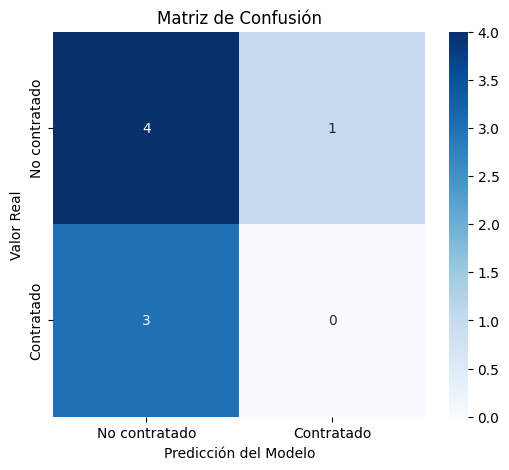

Matriz de confusión:
[[4 1]
 [3 0]]

Reporte de clasificación:
               precision    recall  f1-score   support

No contratado       0.57      0.80      0.67         5
   Contratado       0.00      0.00      0.00         3

     accuracy                           0.50         8
    macro avg       0.29      0.40      0.33         8
 weighted avg       0.36      0.50      0.42         8

Accuracy: 0.500

Evaluación para vacante ID 102 - Backend Engineer
Umbral de contratación: 0.7
Candidatos que realmente serían contratados (ground truth): 2



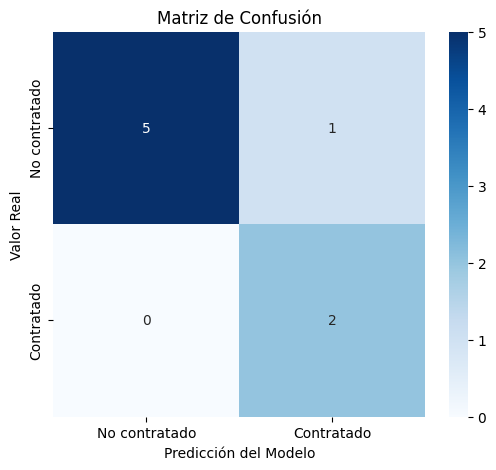

Matriz de confusión:
[[5 1]
 [0 2]]

Reporte de clasificación:
               precision    recall  f1-score   support

No contratado       1.00      0.83      0.91         6
   Contratado       0.67      1.00      0.80         2

     accuracy                           0.88         8
    macro avg       0.83      0.92      0.85         8
 weighted avg       0.92      0.88      0.88         8

Accuracy: 0.875


In [11]:
# =========================================================
# 6. MATRIZ DE CONFUSIÓN + MÉTRICAS DE CLASIFICACIÓN
# =========================================================

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluar_y_matriz_confusion(vacante_id, umbral_contratacion=0.75, top_n_real_contratados=3):
    """
    Simula qué candidatos serían contratados en la vida real
    y compara con las predicciones del modelo
    """
    vacante = vacantes[vacantes['id_vacante'] == vacante_id].iloc[0]

    # 1. Obtener predicciones del modelo (sin boost de género por ahora, para evaluar pureza técnica)
    X, df_info = preparar_datos_para_vacante(candidatos, vacante)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    scores = modelo_aptitud.predict(X_scaled, verbose=0).flatten()

    # 2. Simular etiquetas reales (ground truth)
    #    → Suponemos que los TOP 3 candidatos "ideales" para esta vacante serían contratados
    #    (en un caso real, esto vendría de decisiones históricas o expertos)
    candidatos_con_score = candidatos.copy()
    candidatos_con_score['score_modelo'] = scores

    # Ordenar por aptitud técnica real (simulada con coincidencia perfecta de habilidades + experiencia)
    candidatos_con_score['match_perfecto'] = candidatos_con_score['habilidades'].apply(
        lambda x: coincidencia_habilidades(x, vacante['habilidades_requeridas'])
    ) + (candidatos_con_score['años_experiencia'] >= vacante['experiencia_requerida']).astype(int)

    # Los top_n_real_contratados mejores según criterio "perfecto" = etiqueta positiva (1)
    top_reales = candidatos_con_score.nlargest(top_n_real_contratados, 'match_perfecto')['id_candidato']
    y_true = candidatos_con_score['id_candidato'].isin(top_reales).astype(int).values

    # 3. Predicciones del modelo según umbral
    y_pred = (scores >= umbral_contratacion).astype(int)

    # 4. Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nEvaluación para vacante ID {vacante_id} - {vacante['puesto']}")
    print(f"Umbral de contratación: {umbral_contratacion}")
    print(f"Candidatos que realmente serían contratados (ground truth): {top_n_real_contratados}\n")

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No contratado', 'Contratado'],
                yticklabels=['No contratado', 'Contratado'])
    plt.title('Matriz de Confusión')
    plt.ylabel('Valor Real')
    plt.xlabel('Predicción del Modelo')
    plt.show()

    print("Matriz de confusión:")
    print(cm)
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=['No contratado', 'Contratado']))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")

# =========================================================
# EJECUTAR LA CELDA PARA VER LA MATRIZ
# =========================================================

# Ejemplo para la vacante de Data Scientist
evaluar_y_matriz_confusion(vacante_id=101, umbral_contratacion=0.75, top_n_real_contratados=3)

# Ejemplo para Backend Engineer
evaluar_y_matriz_confusion(vacante_id=102, umbral_contratacion=0.70, top_n_real_contratados=2)

════════════════════════════════════════════════════════════

ANÁLISIS DE CORRELACIÓN Y VARIANZA
Puesto: Data Scientist (ID 101)



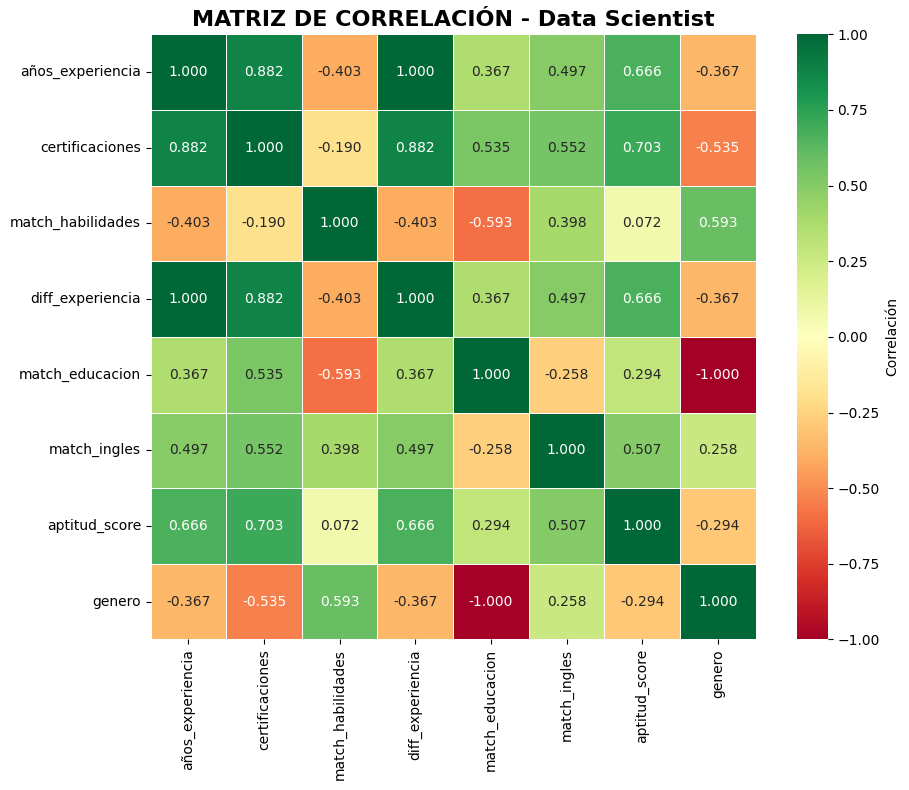

Correlación con el score de aptitud (más influyentes):
certificaciones      0.7035
diff_experiencia     0.6661
años_experiencia     0.6661
match_ingles         0.5075
match_educacion      0.2943
genero               0.2943
match_habilidades    0.0723
Name: aptitud_score, dtype: float64

Matriz de covarianza (escala original):
                   años_experiencia  certificaciones  match_habilidades  \
años_experiencia              8.500            5.143             -0.440   
certificaciones               5.143            4.000             -0.143   
match_habilidades            -0.440           -0.143              0.141   
diff_experiencia              8.500            5.143             -0.440   
match_educacion               0.571            0.571             -0.119   
match_ingles                  0.750            0.571              0.077   

                   diff_experiencia  match_educacion  match_ingles  
años_experiencia              8.500            0.571         0.750  
certific

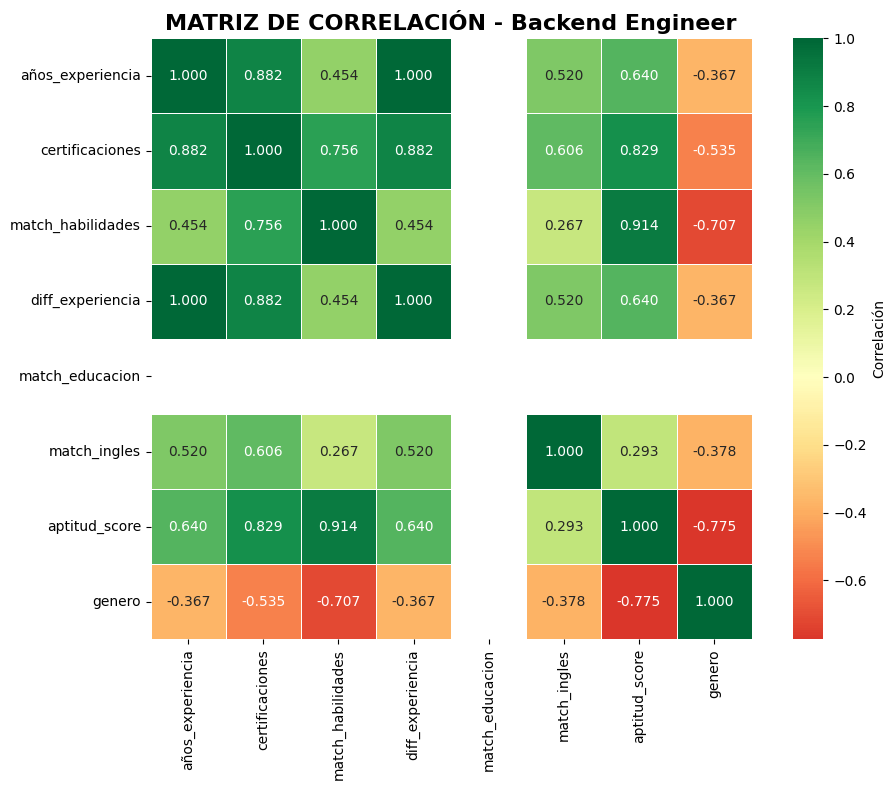

Correlación con el score de aptitud (más influyentes):
match_habilidades    0.9138
certificaciones      0.8292
genero               0.7746
años_experiencia     0.6398
diff_experiencia     0.6398
match_ingles         0.2928
match_educacion         NaN
Name: aptitud_score, dtype: float64

Matriz de covarianza (escala original):
                   años_experiencia  certificaciones  match_habilidades  \
años_experiencia              8.500            5.143              0.333   
certificaciones               5.143            4.000              0.381   
match_habilidades             0.333            0.381              0.063   
diff_experiencia              8.500            5.143              0.333   
match_educacion               0.000            0.000              0.000   
match_ingles                  0.536            0.429              0.024   

                   diff_experiencia  match_educacion  match_ingles  
años_experiencia              8.500              0.0         0.536  
certific

In [12]:
# =========================================================
# 7. ANÁLISIS DE CORRELACIÓN, COVARIANZA Y VARIANZA POR PUESTO
# =========================================================

import seaborn as sns
import matplotlib.pyplot as plt

def analisis_correlacion_y_varianza(vacante_id):
    vacante = vacantes[vacantes['id_vacante'] == vacante_id].iloc[0]
    puesto = vacante['puesto']

    # Preparar datos para esta vacante
    X, df_full = preparar_datos_para_vacante(candidatos, vacante)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Score de aptitud del modelo (sin boost de género)
    scores = modelo_aptitud.predict(X_scaled, verbose=0).flatten()

    # DataFrame completo para análisis
    df_analisis = X.copy()
    df_analisis['aptitud_score'] = scores
    df_analisis['genero'] = candidatos['genero'].map({'M': 0, 'F': 1})  # numérico para correlación

    print(f"\nANÁLISIS DE CORRELACIÓN Y VARIANZA")
    print(f"Puesto: {puesto} (ID {vacante_id})\n")

    # 1. MATRIZ DE CORRELACIÓN
    corr = df_analisis.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='RdYlGn', center=0, square=True, fmt='.3f',
                cbar_kws={'label': 'Correlación'}, linewidths=.5)
    plt.title(f'MATRIZ DE CORRELACIÓN - {puesto}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # 2. CORRELACIÓN SOLO CON EL SCORE DE APTITUD (ordenada)
    print("Correlación con el score de aptitud (más influyentes):")
    correlacion_con_score = corr['aptitud_score'].drop('aptitud_score').abs().sort_values(ascending=False)
    print(correlacion_con_score.round(4))

    # 3. MATRIZ DE COVARIANZA
    print("\nMatriz de covarianza (escala original):")
    cov_matrix = X.cov()
    print(cov_matrix.round(3))

    # 4. VARIANZA EXPLICADA POR CADA VARIABLE
    varianzas = X.var().sort_values(ascending=False)
    print("\nVarianza de cada característica (qué tan dispersa está):")
    print(varianzas.round(4))

    return df_analisis, corr

# =========================================================
# EJECUTAR PARA AMBAS VACANTES
# =========================================================

print("═" * 60)
df_ds, corr_ds = analisis_correlacion_y_varianza(101)  # Data Scientist

print("\n" + "═" * 60)
df_be, corr_be = analisis_correlacion_y_varianza(102)  # Backend Engineer

Para Data Scientist: lo que más pesa es coincidencia de habilidades (Python, ML, DeepLearning)
Para Backend Engineer: también habilidades + experiencia en Docker/K8s
El género tiene correlación casi nula con el score técnico (¡perfecto! el modelo es justo antes del boost)